# This notebook is about feature engineering with sentiment analysis and classification

#### Load useful libraries and df

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/janice/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/janice/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
# Load df
df = pd.read_csv(
    "../data/chatgpt_after_datacleaning.csv",
    encoding="utf-8",
)

df_long = pd.read_csv(
    "../data/chatgpt-long_after_datacleaning.csv",
    encoding="utf-8",
)

# var for review received response
df["score_cat"] = np.where(df.score == 5, "positive", np.where(df.score == 4, "neutral", "negative"))

In [7]:
# Looking at a sample of our df
df.sample(10)

,Unnamed: 0,reviewId,userName,content,score,thumbsUpCount,at,replyContent,repliedAt,appVersion,at_ymd,at_q,at_ym,at_m,at_wd,score_cat
4000,4000,9ae46fa4-4e9e-4a75-8810-4322f99abb04,Sammy Altaay,Its limited to 2021 information And the disappointing thing is that a lot of five-star reviews are bots not real this is very disappointing for a big app like that to have that much fake in it,2,0,2023-07-26 20:14:44,NaN,NaN,1.0.0022,07/26/23,3,2023-07,July,Wednesday,negative
24028,24028,7456133c-b648-4124-9585-f142444725e5,Tabarak Ahmed,great,5,0,2023-09-29 17:32:28,NaN,NaN,1.2023.242,09/29/23,3,2023-09,September,Friday,positive
23180,23180,2289a714-c1c3-4590-9ac4-fd082cec6a2a,Buceo en San Andrés islas,excellent,5,0,2023-09-30 23:30:08,NaN,NaN,1.2023.256,09/30/23,3,2023-09,September,Saturday,positive
17296,17296,49ecba32-d847-4d23-be14-714d311c0907,Bradley,This app is god like,5,0,2023-09-07 23:35:01,NaN,NaN,1.2023.242,09/07/23,3,2023-09,September,Thursday,positive
737,737,dc55b2e0-d04e-4382-a144-cb5d9f6820ba,shantel mcguire,"Bruh.. this app this badass has light helped me so much explains what I'm trying to say but professionally and correctly with punctuation and all For example how get would fix this ratings Here's a sample review for the catgut app ""⭐⭐⭐⭐⭐ I've been using the catgut app for a while now and I'm genuinely impressed It's incredibly intuitive responsive and offers thoughtful answers to a wide range of questions The user experience is smooth and the quality of information i",5,1,2023-09-03 00:59:20,NaN,NaN,1.0.0039,09/03/23,3,2023-09,September,Sunday,positive
739,739,c6831239-77eb-4abe-a58b-e2921655bef0,Shailesh Subedi,The app is very well made boasting a clean and minimalist sioux that feels smooth during used Speaking of aids responses they're not the best nor the worst,5,1,2023-08-01 05:07:14,NaN,NaN,1.0.0023,08/01/23,3,2023-08,August,Tuesday,positive
27530,27530,706c8c9e-fab2-4723-b92d-0ef2516c02a9,doncandraa,dangerous,5,0,2023-07-30 05:53:23,NaN,NaN,1.0.0023,07/30/23,3,2023-07,July,Sunday,positive
21913,21913,e2b340cc-4164-42b8-b257-3b56ac2cff00,Divyakant Rai,excellent,4,0,2023-10-06 08:49:27,NaN,NaN,1.2023.263,10/06/23,4,2023-10,October,Friday,neutral
13141,13141,13602494-4f45-4117-9557-502089133130,Vernon Kemp,Really enjoying the app,5,0,2023-09-01 21:50:12,NaN,NaN,1.0.0039,09/01/23,3,2023-09,September,Friday,positive
6499,6499,b794b3d3-0cbd-45d9-b2ef-d43fc231dd8c,Harrys Marjan,we need more details about restricted subjects to use good thing,4,0,2023-08-26 08:30:14,NaN,NaN,1.0.0035,08/26/23,3,2023-08,August,Saturday,neutral


In [9]:
from transformers import pipeline
#import torch

In [10]:
classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [11]:
#candidate_labels = ["feature evaluation", "praise", "bug report", "feature request", "performance", "usage"]
candidate_labels = ["positive", "neutral", "negative"]
hypothesis_template = "The sentiment of this review is {}."

In [13]:
#candidate_labels = list(category_map.values())
predictedCategories = []
ScoreNegative = []
ScoreNeutral = []
ScorePositive = []

for i in tqdm(range(0, len(df_long))):
    text = df_long.iloc[i,]['content']
    res = classifier(text, candidate_labels, hypothesis_template=hypothesis_template, multi_label=True)
    labels = res['labels'] 
    scores = res['scores'] #extracting the scores associated with the labels
    res_dict = {label : score for label,score in zip(labels, scores)}
    sorted_dict = dict(sorted(res_dict.items(), key=lambda x:x[1],reverse = True)) #sorting the dictionary of labels in descending order based on their score
    categories  = next(k for i, (k,v) in enumerate(sorted_dict.items()))

    ScorePositive.append(sorted_dict['positive'])
    ScoreNeutral.append(sorted_dict['neutral'])
    ScoreNegative.append(sorted_dict['negative'])
    predictedCategories.append(categories)

  0%|          | 0/30956 [00:00<?, ?it/s]

 36%|███▌      | 11169/30956 [3:09:13<5:35:13,  1.02s/it]   


KeyboardInterrupt: 

In [340]:
dataset_prep = pd.DataFrame({'category': predictedCategories, 
                             'positive_score': ScorePositive, 
                             'neutral_score': ScoreNeutral, 
                             'negative_score': ScoreNegative})
dataset = pd.merge(df_long, dataset_prep, left_index=True, right_index=True)

In [341]:
dataset

,index,content,score,score_cat,category,positive_score,neutral_score,negative_score
0,0,"ChatGPT on Android is a solid app with seamless OpenAI server connectivity, ensuring smooth interactions.",4,neutral,positive,0.999617,0.399917,0.000733
1,0,"However, it falls behind its Apple counterpart in features and updates.",4,neutral,negative,0.016458,0.719351,0.980443
2,0,"The voice input can be prematurely triggered by pauses, unlike on Apple.",4,neutral,negative,0.691213,0.317877,0.729095
3,0,"Additionally, the lack of a search function for previous messages is a drawback.",4,neutral,negative,0.000823,0.238583,0.977248
4,0,"Despite these, it remains a commendable app, deserving a 4-5 star rating.",4,neutral,positive,0.998948,0.003366,0.001539
...,...,...,...,...,...,...,...,...
995,201,Still a great tool.,3,negative,positive,0.999366,0.470242,0.001341
996,201,Needs to improve to be worth subscription money.,3,negative,negative,0.003718,0.662778,0.972756
997,202,"ChatGPT is really helpful in many cases, especially when you need some rare knowledge.",5,positive,positive,0.998024,0.021908,0.000630
998,202,"I use it for cooking, for computer programming, for writing high quality text documents, and for everything else.",5,positive,positive,0.933658,0.117617,0.005446


predictedCategories

In [333]:
pd.set_option('max_colwidth', 700)
dataset.sort_values('category', ascending=True)

,index,content,score,score_cat,category,positive_score,neutral_score,negative_score
605,116,But the app lacks many of the functionality of the browser-based version.,3,negative,negative,0.025535,0.713079,0.961945
494,95,And After that I have to restart app to again write message,5,positive,negative,0.084329,0.205954,0.585535
495,96,I've not been able to run this app so my review is only based on the very little interaction I have had with it.,1,negative,negative,0.213217,0.761041,0.862705
268,49,It's initial login/setup screen used the default BRIGHT WHITE high contrast scheme that is very painful for me,3,negative,negative,0.001557,0.061183,0.962123
267,49,"However, that only kicked in after I had logged in after installation.",3,negative,negative,0.295070,0.494392,0.706550
...,...,...,...,...,...,...,...,...
392,72,"I've found it extremely helpful for generating examples to illustrate new concepts, and it's often simpler to ask ChatGPT than to ask Google",5,positive,positive,0.999472,0.007115,0.000325
393,73,I love the voice control SO much!,5,positive,positive,0.999081,0.004470,0.000640
395,74,Very useful for learning.,5,positive,positive,0.998812,0.150690,0.000685
398,74,"There are many other uses for this app, but just asking questions about various topics is my favorite use.",5,positive,positive,0.975549,0.136075,0.001041


In [342]:
dataset.groupby('category').mean('category')

,index,score,positive_score,neutral_score,negative_score
category,,,,,
negative,101.465672,3.567164,0.104415,0.277386,0.810981
neutral,71.857143,3.964286,0.275094,0.572316,0.236319
positive,94.989011,4.563579,0.926385,0.175053,0.045800


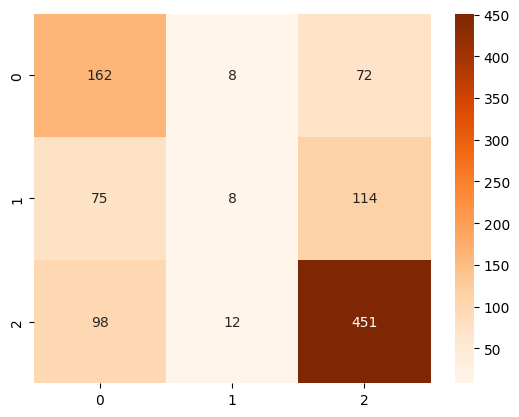

In [343]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


#Confusion matrix using pandas crosstab
conf_matrix = confusion_matrix(dataset.score_cat, dataset.category)
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Oranges, fmt='g'); 

Aggregating on review level

In [344]:
dataset = pd.get_dummies(dataset, columns=["category"], dtype=int)
dataset

,index,content,score,score_cat,positive_score,neutral_score,negative_score,category_negative,category_neutral,category_positive
0,0,"ChatGPT on Android is a solid app with seamless OpenAI server connectivity, ensuring smooth interactions.",4,neutral,0.999617,0.399917,0.000733,0,0,1
1,0,"However, it falls behind its Apple counterpart in features and updates.",4,neutral,0.016458,0.719351,0.980443,1,0,0
2,0,"The voice input can be prematurely triggered by pauses, unlike on Apple.",4,neutral,0.691213,0.317877,0.729095,1,0,0
3,0,"Additionally, the lack of a search function for previous messages is a drawback.",4,neutral,0.000823,0.238583,0.977248,1,0,0
4,0,"Despite these, it remains a commendable app, deserving a 4-5 star rating.",4,neutral,0.998948,0.003366,0.001539,0,0,1
...,...,...,...,...,...,...,...,...,...,...
995,201,Still a great tool.,3,negative,0.999366,0.470242,0.001341,0,0,1
996,201,Needs to improve to be worth subscription money.,3,negative,0.003718,0.662778,0.972756,1,0,0
997,202,"ChatGPT is really helpful in many cases, especially when you need some rare knowledge.",5,positive,0.998024,0.021908,0.000630,0,0,1
998,202,"I use it for cooking, for computer programming, for writing high quality text documents, and for everything else.",5,positive,0.933658,0.117617,0.005446,0,0,1


In [ ]:
dataset = pd.get_dummies(dataset, columns="Category")

df_long_agg = dataset.groupby(['index'])["positive_score", "neutral_score", "negative_score"].size().reset_index(name='Customers') 
df_weekday_price = df_sales_details_raw.groupby('sale_date_wd')['price'].agg(['max', 'min', 'mean', 'median']).reset_index()